# Handling a long input

Find a long video you'd like to process and put it on GCS:

In [2]:
video_uri = "PUT_YOUR_GCS_URI_HERE"

In [3]:
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_google_vertexai import ChatVertexAI

human_part = {"type": "text", "text": "Provide a summary of the video."}

def _create_input_messages(*, video_uri: str, chunks: int = 5, interval_secs: int = 600):
  video_parts = []
  for start_offset in range(chunks):
    part = {
        "type": "media", "file_uri": video_uri, "mime_type": "video/mp4",
        "video_metadata": {
            "start_offset": {"seconds": start_offset*interval_secs},
            "end_offset": {"seconds": (start_offset+1)*interval_secs}}
    }
    video_parts.append(part)
  return [[HumanMessage(content=[human_part, vp])] for vp in video_parts]


input_messages = _create_input_messages(video_uri=video_uri)
llm = ChatVertexAI(model="gemini-2.0-flash-001")
map_chain = llm | StrOutputParser()

summaries = map_chain.batch(input_messages, config={"max_concurrency": 3})

In [4]:
from langchain_core.runnables import RunnableLambda

create_inputs_chain = RunnableLambda(lambda x: _create_input_messages(**x))
map_step_chain = create_inputs_chain | RunnableLambda(lambda x: map_chain.batch(x, config={"max_concurrency": 3}))
summaries =  map_step_chain.invoke({"video_uri": video_uri})

Let's define a function to merge summaries together:

In [6]:
from langchain_core.prompts import PromptTemplate

def _merge_summaries(summaries: list[str], interval_secs: int = 600, **kwargs) -> str:
  sub_summaries = []
  for i, summary in enumerate(summaries):
    sub_summary = (
        f"Summary from sec {i*interval_secs} to sec {(i+1)*interval_secs}:"
        f"\n{summary}\n")
    sub_summaries.append(sub_summary)
  return "".join(sub_summaries)


reduce_prompt = PromptTemplate.from_template(
    "You are given a list of summaries that "
    "of a video splitted into sequential pieces.\n"
    "SUMMARIES:\n{summaries}"
    "Based on that, prepare a summary of a whole video."
    )


reduce_chain = RunnableLambda(lambda x: _merge_summaries(**x)) | reduce_prompt | llm | StrOutputParser()
final_summary = reduce_chain.invoke({"summaries": summaries})


In [7]:
print(final_summary)

## Google Cast: Evolution and Future - A Comprehensive Summary

This video, featuring Majd Bakar and John Affaki, explores the evolution of Google Cast and provides insights into its future direction.

**Introduction (0-600 seconds):**

The video begins by highlighting the success of Chromecast, a revolutionary $35 device that extends content from mobile devices to HDTVs. The Google Cast SDK and developer program, boasting over 6,000 developers, have been instrumental in expanding the casting ecosystem. The core vision for Google Cast revolves around: redefining interaction models with television (moving away from cumbersome experiences with technologies like gyroscopes and cameras), building a robust ecosystem, ensuring an open platform, and delivering a consistent user experience.  The ubiquity of mobile devices allows developers to focus on function without compromising form. The SDK is available for Android, iOS, and Web Apps in Chrome, and over 50% of Chromecast users utilize mult

Let's implement a reduce step that merges intermediatesummaries together:

In [8]:
from langchain.chains import LLMChain
reduce_chain = RunnableLambda(lambda x: _merge_summaries(**x)) | LLMChain(llm=llm, prompt=reduce_prompt, output_parser=StrOutputParser())


/var/folders/5r/vzx_gv654ss9pc9897_bh5nm00gtqf/T/ipykernel_57112/1160931248.py:2: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  reduce_chain = RunnableLambda(lambda x: _merge_summaries(**x)) | LLMChain(llm=llm, prompt=reduce_prompt, output_parser=StrOutputParser())


In [9]:
from langchain_core.runnables import RunnablePassthrough

final_chain = (
    RunnablePassthrough.assign(summaries=map_step_chain).assign(final_summary=reduce_chain)
    | RunnableLambda(lambda x: x["final_summary"])
)

result = final_chain.invoke({"video_uri": video_uri, "interval_secs": 300, "chunks": 9})

In [10]:
result = final_chain.invoke({"video_uri": video_uri, "interval_secs": 300, "chunks": 9})
print(result)

{'summaries': 'Summary from sec 0 to sec 300:\nSure, here is a summary of the video.\n\nThe video “Casting to the Future” by Google I/O details the goals that Google wants to achieve.\n\nThe main goals are:\n- Redefine the interaction model;\n- Build an ecosystem;\n- Make it open;\n- Consistent experience. \n\nWith Google Chromecast, the video notes that “Google Cast goes beyond Chromecast” in that Google seeks to extend reach to more devices, and wants consumers to have a choice of devices to use to consume their content. Google also wants developers to build their application using a consistent model for all devices.\nSummary from sec 300 to sec 600:\nHere is a summary of the video.\n\nThe speaker talks about how easy it is to cast enable apps. All developers need to do is integrate discovery and control with the cast SDK, and their app will be up and running. To make this easy, cast SDK has been enabled across three most popular platforms: Android, iOS and Chrome.\nThe speaker also 

## Using LangGraph

Let's implement the same logic using LangGraph:

In [12]:
import operator
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.constants import Send
from langgraph.graph import StateGraph, START, END


class AgentState(TypedDict):
    video_uri: str
    chunks: int
    interval_secs: int
    summaries: Annotated[list, operator.add]
    final_summary: str

class _ChunkState(TypedDict):
    video_uri: str
    start_offset: int
    interval_secs: int


human_part = {"type": "text", "text": "Provide a summary of the video."}

async def _summarize_video_chunk(state:  _ChunkState):
    start_offset = state["start_offset"]
    interval_secs = state["interval_secs"]
    video_part = {
        "type": "media", "file_uri": state["video_uri"], "mime_type": "video/mp4",
        "video_metadata": {
            "start_offset": {"seconds": start_offset*interval_secs},
            "end_offset": {"seconds": (start_offset+1)*interval_secs}}
    }
    response = await llm.ainvoke(
        [HumanMessage(content=[human_part, video_part])])
    return {"summaries": [response.content]}

def _map_summaries(state: AgentState):
    chunks = state["chunks"]
    payloads = [
        {
            "video_uri": state["video_uri"],
            "interval_secs": state["interval_secs"],
            "start_offset": i
        } for i in range(state["chunks"])
    ]
    return [Send("summarize_video_chunk", payload) for payload in payloads]

async def _generate_final_summary(state: AgentState):
    summary = _merge_summaries(
        summaries=state["summaries"], interval_secs=state["interval_secs"])
    final_summary = await (reduce_prompt | llm | StrOutputParser()).ainvoke({"summaries": summary})
    return {"final_summary": final_summary}

graph = StateGraph(AgentState)
graph.add_node("summarize_video_chunk", _summarize_video_chunk)
graph.add_node("generate_final_summary", _generate_final_summary)

graph.add_conditional_edges(START, _map_summaries, ["summarize_video_chunk"])
graph.add_edge("summarize_video_chunk", "generate_final_summary")
graph.add_edge("generate_final_summary", END)

app = graph.compile()

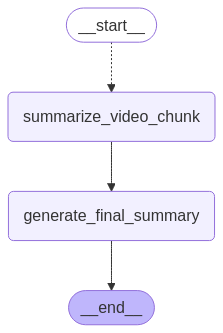

In [13]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [16]:
result = await app.ainvoke(
    {"video_uri": video_uri, "chunks": 5, "interval_secs": 600},
    {"max_concurrency": 3}
)
print(result["final_summary"])

Okay, here's a comprehensive summary of the entire video, synthesized from the individual section summaries:

**Overall Video Summary:**

The video features Google Engineers Majid Abakar and John Afaki discussing the evolution of Google Cast and its future direction. They highlight Google Cast's goals: redefining TV interaction, offering compelling large-screen experiences, building an open and consistent ecosystem for both users and developers.

The presentation covers several key areas:

*   **Introduction to Google Cast:** It started with Chromecast for $35 and now encompasses a broader vision of bringing content to the largest screen possible using mobile devices as controllers.
*   **Interaction Model:** Focuses on seamless content consumption on large screens, leveraging mobile device portability. The user can use the cloud, their mobile device or the local cloud on other devices. With the ability to connect multiple mobile devices to a single session, this media app can bring gr

In [17]:
async for step in app.astream(
    {"video_uri": video_uri, "chunks": 5, "interval_secs": 600},
    {"recursion_limit": 10},
):
    print(list(step.keys()))

['summarize_video_chunk']
['summarize_video_chunk']
['summarize_video_chunk']
['summarize_video_chunk']
['summarize_video_chunk']
['generate_final_summary']


Let's look at the final summary:

In [18]:
result["final_summary"]

"Okay, here's a comprehensive summary of the entire video, synthesized from the individual section summaries:\n\n**Overall Video Summary:**\n\nThe video features Google Engineers Majid Abakar and John Afaki discussing the evolution of Google Cast and its future direction. They highlight Google Cast's goals: redefining TV interaction, offering compelling large-screen experiences, building an open and consistent ecosystem for both users and developers.\n\nThe presentation covers several key areas:\n\n*   **Introduction to Google Cast:** It started with Chromecast for $35 and now encompasses a broader vision of bringing content to the largest screen possible using mobile devices as controllers.\n*   **Interaction Model:** Focuses on seamless content consumption on large screens, leveraging mobile device portability. The user can use the cloud, their mobile device or the local cloud on other devices. With the ability to connect multiple mobile devices to a single session, this media app ca